these exercises are from the Quantitative Neuroscience course at UPenn by Josh Gold

In [24]:
import platform
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import poisson
from scipy.stats import chi2
import scipy.stats as st
import collections
import time
from IPython.display import clear_output
from statsmodels.stats import proportion

print(platform.python_version()) # 3.8.3

3.8.3


In [17]:
# Ex 1
n = 10 # number of available quanta
p_release = 0.2 # release probability
k = np.arange(11) # possible values of k (measured events)
probs = binom.pmf(k,n,p_release) # array of probs of obtaining k given args n and p_release

for A, B in zip(k, probs):
    print(f'k={A:2d}: p={B:.2f}')

k= 0: p=0.11
k= 1: p=0.27
k= 2: p=0.30
k= 3: p=0.20
k= 4: p=0.09
k= 5: p=0.03
k= 6: p=0.01
k= 7: p=0.00
k= 8: p=0.00
k= 9: p=0.00
k=10: p=0.00


In [18]:
# Ex 2
n = 14 # number of available quanta
k = 8 # measured number of released quanta

# Compute pdf from range of p values from 0.1 to 1.0 in 0.1 sized steps
ps = np.arange(0.1,1.0,0.1)
probs = [binom.pmf(k,n,x) for x in ps]

for A, B in zip(ps, probs):
    print(f'p={A:.1f}: binomial probability={B:.4f}')

p=0.1: binomial probability=0.0000
p=0.2: binomial probability=0.0020
p=0.3: binomial probability=0.0232
p=0.4: binomial probability=0.0918
p=0.5: binomial probability=0.1833
p=0.6: binomial probability=0.2066
p=0.7: binomial probability=0.1262
p=0.8: binomial probability=0.0322
p=0.9: binomial probability=0.0013


Total probability = 1.24e-07, total log probability = -15.905


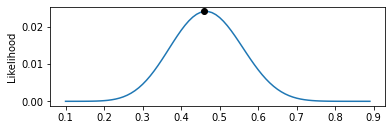

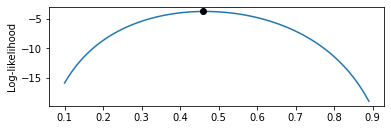

In [19]:
# Ex 3
n1 = 14 # experiment 1 available quanta
n2 = 14 # '' experiment 2
k1 = 8 # measured number released exp 1
k2 = 5 # '' experiment 2
p_release = 0.1 # assumed probability of release

prob1 = binom.pmf(k1, n1, p_release) # prob of obtaining k1 given n1 and p_release
prob2 = binom.pmf(k2, n2, p_release) # '' k2 given n2 and p_release

total_prob = prob1*prob2 # assume independence and compute product
total_log_prob = np.log(prob1) + np.log(prob2) # ''

# Display probabilities
print(f'Total probability = {total_prob:.3}, total log probability = {total_log_prob: .3f}')

# Likelihood and log-likelihood fxns for sample size = 2
ps = np.arange(0.1, 0.9, 0.01) # array of release probs with resolution 0.01

# Get value of binomial distribution for each combo of k,n,p_release
probs = binom.pmf(matlib.repmat([k1,k2], ps.size,1), matlib.repmat([n1,n2], ps.size,1), 
                  matlib.repmat(np.asmatrix(ps).T,1,2)) # output is a matrix with 2 columns

# Likelihood fxn is the product of likelihoods assuming independence
plt.subplot(211)
plt.ylabel('Likelihood')
likelihood_fxn = np.prod(probs,1) # compute product for each row
plt.plot(ps,likelihood_fxn) # plot
max_likelihood = np.amax(likelihood_fxn) # get max likelihood
plt.plot(ps[likelihood_fxn == max_likelihood], max_likelihood, 'ko')
plt.show()

# Log-likelihood fxn is the sum of log-likelihoods
plt.subplot(212)
plt.ylabel('Log-likelihood')
log_likelihood_fxn = np.sum(np.log(probs),1) # compute the sum for each row
plt.plot(ps, log_likelihood_fxn) # plot
max_log_likelihood = np.amax(log_likelihood_fxn) # get max likelihood
plt.plot(ps[log_likelihood_fxn == max_log_likelihood], max_log_likelihood, 'ko')
plt.show()

In [23]:
# Top plot: normalized histogram of simulated experimental outcomes
# with the theoretical binomial distribution

# Middle plot: likelihood fxn, p(simulated data | p_release)

# Bottom plot: log-likelihood fxn

fig, axs = plt.subplots(3, 1, figsize = (8,11))
n = 14 # number of available quanta
p_release = 0.3 # assumed prob of release
ks = np.arange(0, n) # possible values of k
ps = np.arange(0.01, 0.99, 0.01) # possible release probs

TINY = 0.0001 # to avoid taking logs of really small numbers

for sample_size in np.logspace(0, 3, 30): # try diff sample sizes

    # Simulate experiments 
    simulated_counts = binom.rvs(n, p_release, size = int(np.round(sample_size)))
    
    # Plot experiment, theoretical binomial pdf
    plt.sca(axs[0])
    axs[0].cla()
    plt.title(f'Sample size = {int(np.round(sample_size))}')
    plt.ylabel('Probability')
    plt.xlabel('Release count')
    plt.xlim((ks[1], ks[-1]))
    
    # Plot normalized histogram of simulated counts
    plt.hist(simulated_counts, np.arange(-0.5, n + 0.5, 1), density=True)
    
    # Plot theoretical pdf
    plt.plot(ks, binom.pmf(ks, n, p_release), 'ro-')
    
    # Compute log likelihood for each p
    likelihoods = np.zeros((ps.size, 2))
    
    # Loop through each possible value of release probability
    for p_index, p_value in enumerate(ps):
        
        # Compute probability given assumed release probability
        probs = binom.pmf(simulated_counts, n, p_value)
        
        # Avoid really small numbers by setting them to TINY variable
        probs[probs<TINY] = TINY
        
        # Save product of likelihoods and sum of log likelihoods
        likelihoods[p_index, 0] = np.prod(probs)
        likelihoods[p_index, 1] = np.sum(np.log(probs))
        
        # Get 95% CIs for max likelihood binomial fit value of p
        # Assume all measurements are independent and lumps them together
        ci_low, ci_upp = proportion.proportion_confint(np.sum(simulated_counts), 
                                                       sample_size*n)
        
        # Plot product of likelihoods
        plt.sca(axs[1])
        axs[1].cla()
        plt.ylabel('likelihood')
        
        # Plot the likelihood function (product of likelihoods)
        plt.plot(ps, likelihoods[:,0])
        
        # Find the maximum
        max_lik = np.max(likelihoods[:,0])
        
        # Show the actual p_release value as a dashed line
        plt.plot([p_release, p_release], [0, max_lik], 'r--')
        
        # Show 95% CIs from the fits
        plt.plot([ci_low, ci_upp], [max_lik, max_lik], 'm-', linewidth=2)
        
        # Show max value of computed likelihood fxn
        plt.plot(ps[np.atleast_1d(np.argmax(likelihoods[:,0]))[0]], 
                 max_lik, 'k*', markersize = 12)
        
        # Plot the sum of log-likelihoods
        plt.sca(axs[2])
        axs[2].cla()
        plt.ylabel('Log likelihood')
        plt.xlabel('Release probability')
        
        # Plot the likelihood fxn 
        plt.plot(ps, likelihoods[:,1])
        
        # Find the maximum
        max_loglik = np.max(likelihoods[:,1])
        
        # Show the actual p_release value as dashed line
        plt.plot([p_release, p_release], [0, np.min(likelihoods[:,1])], 'r--')
        
        # Show the 95% CIs from the fits
        plt.plot([ci_low, ci_upp], [max_lik, max_lik], 'm-', linewidth=2)
        
        # Show the max value of our computed likelihood fxn
        plt.plot(ps[np.atleast_1d(np.argmax(likelihoods[:,1]))[0]], 
                 max_loglik, 'k*', markersize = 12)
        
        # Make the figure look better
        plt.subplots_adjust(hspace=0.3)
        plt.show()
        
        # Wait
        time.sleep(0.5)
        
        # Clear for next plot
        clear_output(wait=True)

# Note 1: as sample size increases,  ability to estimate true value of p_release increases
# Note 2: as # of samples increases, total likelihood disappears eventually

KeyboardInterrupt: 

In [27]:
# Ex 4

# Set up experiment
counts = [0, 0, 3, 10, 19, 26, 16, 16, 5, 5, 0, 0, 0, 0, 0] # experimental outcomes

n = len(counts) - 1 # number of available quanta in each experiment
ks = np.arange(n+1) # possible values of k
ps = np.arange(0, 1.01, 0.01) # possible values of release prob as column vector

# COmpute value of binomial distribution for each value of k,n,p
# Columns correspond to diff values of p
# Rows correspond to diff values of k
probs = binom.pmf(matlib.repmat(ks, ps.size, 1), n, 
                  matlib.repmat(np.asmatrix(ps).T, 1, ks.size))

# Make matrix of outcomes in rows to compute likelihoods for each ps
counts_matrix = matlib.repmat(counts, ps.size, 1)

# Compute likelihood fxn, which takes the product of all likelihoods of each outcome
likelihood_fxn = np.prod(probs ** counts_matrix, axis=1)
p_hat_from_likelihood = ps[np.argmax(likelihood_fxn)]

# Compute log-likelihood fxn which takes sum of all log-likelihoods
probs[probs<TINY]=TINY
log_likelihood_fxn = np.sum(np.log(probs) * counts_matrix, axis=1)
p_hat_from_log_likelihood = ps[np.argmax(log_likelihood_fxn)]

# Compute p directly from empirical data
p_empirical = np.sum(counts*ks)/(np.sum(counts) * n)

# Show results
print(f'p = {p_hat_from_likelihood:.3f} from likelihood, {p_hat_from_log_likelihood:.3f} from log-likelihood, {p_empirical:.3f} directly')

p = 0.380 from likelihood, 0.380 from log-likelihood, 0.382 directly


In [28]:
# Ex 5

n = 14 # number of avilable quanta
k = 7 # number of released quanta
p_hat = k/n # compute max-likelihood value of p
p_null= 0.3 # Null hypothesis p

# Get p-value for one-sided that you would have gotten k or more successes in n trials
p_value = st.binom_test(k, n, p_null, alternative = 'greater')

# Show displays
print(f'p value for the null hypothesis that p={p_null:.1f} = {p_value:.4f}')

p value for the null hypothesis that p=0.3 = 0.0933


row=0, goodness-of-fits, binomial p=0.992, Poisson p=0.950
row=1, goodness-of-fits, binomial p=0.849, Poisson p=0.833
row=2, goodness-of-fits, binomial p=0.999, Poisson p=0.891
row=3, goodness-of-fits, binomial p=0.988, Poisson p=0.200
row=4, goodness-of-fits, binomial p=0.760, Poisson p=0.015
row=5, goodness-of-fits, binomial p=1.000, Poisson p=0.000


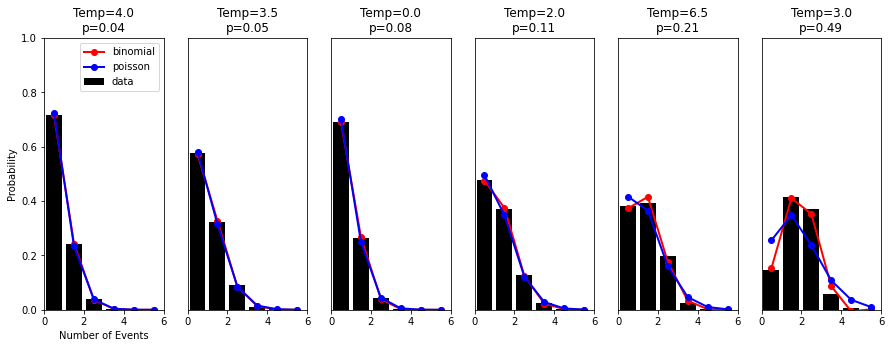

In [30]:
# Ex 6

# Set up the figure
fig = plt.figure(figsize = (15,5))

# Data table
data = np.asarray([
   [4.0, 615, 206, 33,  2,  0, 0],
   [3.5, 604, 339, 94,  11, 2, 0],
   [0.0, 332, 126, 21,  1,  0, 0],
   [2.0, 573, 443, 154, 28, 2, 0],
   [6.5, 172, 176, 89,  12, 1, 0],
   [3.0, 80,  224, 200, 32, 4, 0]])

xs = np.arange(6) # x-axis

# For each session
for index, row in enumerate(data):
    
    # Compute relevant variables
    nx = row[1:] # count data
    N = np.sum(nx) # total number of trials
    m = np.sum(nx[1:] * xs[1:])/N # mean
    v = np.sum((xs - m) ** 2 * nx)/N # variance
    p = 1 - (v/m) # release probability
    n = m/p # available quanta per trial
    
    # Set up the plot 
    ax = plt.subplot(1, len(data), index + 1)
    plt.bar(xs + 0.5, nx/N, facecolor = 'k')
    
    # Compute binomial probs
    binomial_counts = np.zeros(xs.size)
    binomial_counts[0] = np.sum(nx) * (1-p) ** n
    
    for idx in np.arange(1, binomial_counts.size):
        binomial_counts[idx] = binomial_counts[idx-1] * (m - p*(idx - 1))/((idx)*(1-p))
    
    binomial_counts = np.round(binomial_counts)
    
    # Normalize for pdf and plot
    plt.plot(xs + 0.5, binomial_counts/np.sum(binomial_counts), 
             'ro-', markerfacecolor='r', linewidth=2)
    
    # Get poisson pdf
    pps = poisson.pmf(xs, m)
    plt.plot(xs + 0.5, pps, 'bo-', markerfacecolor='b', linewidth=2)
    
    # Compute chi^2 goodness of fit with k-1 degrees of freedom
    with np.errstate(invalid = 'ignore', divide='ignore'):
        pb = 1 - chi2.cdf(np.nansum(np.divide((nx - binomial_counts) **2 , 
                                            binomial_counts)), binomial_counts.size - 1)
        poisson_counts = np.round(pps*N)
        pp = 1 - chi2.cdf(np.nansum(np.divide((nx - poisson_counts)**2, 
                                            poisson_counts)), poisson_counts.size -1)
    
    print(f'row={index}, goodness-of-fits, binomial p={pb:.3f}, Poisson p={pp:.3f}')
    
    # Title, labels, legend
    plt.axis([0, 6, 0, 1])
    plt.title(f'Temp={row[0]:.1f}\np={p:.2f}')
    if index == 0:
        plt.xlabel('Number of Events')
        plt.ylabel('Probability')
        plt.legend(('binomial', 'poisson', 'data'))
    else:
        ax.get_yaxis().set_ticks([])
    